In [1]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

truedata = np.load("3RETransits300ppm_Large.npy", allow_pickle = True)
falsedataA = np.load("falsepositive300a.npy", allow_pickle = True)
falsedataB = np.load("falsepositive300b.npy", allow_pickle = True)
falsedata = np.append(falsedataA, falsedataB)

In [21]:
# make categories list
y_false = np.full(len(falsedata),0,dtype = int)
y_true = np.full(len(truedata),1,dtype = int)

y = np.append(y_false,y_true)

folded_flux = falsedata[0].folded_y
false_phasefolds = np.zeros((len(falsedata),len(folded_flux),1))
folded_flux = truedata[0].folded_y
true_phasefolds = np.zeros((len(truedata),len(folded_flux),1))

for i, data in enumerate(falsedata):
    folded_flux = data.folded_y
    for j, point in enumerate(folded_flux):
        false_phasefolds[i,j] = folded_flux[j]

for i, data in enumerate(truedata):
    folded_flux = data.folded_y
    for j, point in enumerate(folded_flux):
        true_phasefolds[i,j] = folded_flux[j]

x = np.concatenate((false_phasefolds, true_phasefolds))
print(x.shape)
print(y.shape)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X = shuffle(x)
Y = shuffle(y)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.3)

(4999, 1200, 1)
(4999,)


In [50]:


# CNN found on https://github.com/pearsonkyle/Exoplanet-Artificial-Intelligence/blob/master/shallue_vanderburg_recreation.py

input_global = Input(shape=x_train.shape[1:])
x = Conv1D(16, 5, strides=1)(input_global)
x = Conv1D(16, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(32, 5, strides=1)(x)
x = Conv1D(32, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(64, 5, strides=1)(x)
x = Conv1D(64, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(128, 5, strides=1)(x)
x = Conv1D(128, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)
x = Conv1D(256, 5, strides=1)(x)
x = Conv1D(256, 5, strides=1)(x)
x = MaxPooling1D(pool_size=5, strides=2)(x)

xf = Flatten()(x)
z = Dense(512, activation='relu')(xf)
z = Dense(512, activation='relu')(z)
z = Dense(512, activation='relu')(z)

output = Dense(1, activation='sigmoid', name='main_output')(z)

model = Model(inputs=input_global, outputs=output)

model.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1200, 1)]         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1196, 16)          96        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1192, 16)          1296      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 594, 16)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 590, 32)           2592      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 586, 32)           5152      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 291, 32)         

In [57]:
from tensorflow.keras.metrics import Accuracy

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [Accuracy(name='acc')])

In [58]:
batch_size = 64
hist = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/50
55/55 [==============================] - 13s 231ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 2/50
55/55 [==============================] - 13s 243ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 3/50
55/55 [==============================] - 13s 230ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 4/50
55/55 [==============================] - 13s 233ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 5/50
55/55 [==============================] - 12s 215ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 6/50
55/55 [==============================] - 12s 210ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - val_loss: 2.4239e-08 - val_acc: 0.0000e+00
Epoch 7/50
55/55 [==============================] - 12s 211ms/step - loss: 2.3678e-08 - acc: 0.0000e+00 - 

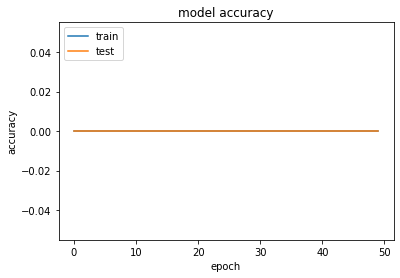

In [59]:
# Plot model accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()